DGL at a Glance
=========================

The goal of this tutorial:

- Understand how DGL enables computation on graph from a high level.
- Train a simple graph neural network in DGL to classify nodes in a graph.

At the end of this tutorial, we hope you get a brief feeling of how DGL works.

*This tutorial assumes basic familiarity with pytorch.*

Tutorial problem description
---------------------------

The tutorial is based on the "Zachary's karate club" problem. The karate club
is a social network that includes 34 members and documents pairwise links
between members who interact outside the club.  The club later divides into
two communities led by the instructor (node 0) and the club president (node
33). The network is visualized as follows with the color indicating the
community:

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/img/karate-club.png)

The task is to predict which side (0 or 33) each member tends to join given
the social network itself.



Step 1: Creating a graph in DGL
-------------------------------
Load the graph for Zachary's karate club as follows:



In [1]:
from dataset import KarateClub
dataset = KarateClub()
G = dataset[0]

Print out the number of nodes and edges in our newly constructed graph:



In [2]:
print('Karate club graph has %d nodes.' % G.number_of_nodes())
print('Karate club graph has %d edges.' % G.number_of_edges())

Karate club graph has 34 nodes.
Karate club graph has 156 edges.


Visualize the graph by converting it to a networkx graph:

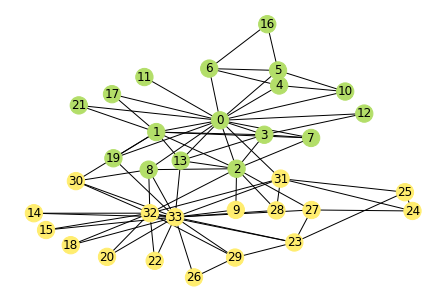

In [16]:
import networkx as nx
from matplotlib import pyplot as plt
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, cmap=plt.get_cmap('Set3'), node_color=G.ndata['label'], vmin=-1, vmax=1)

Step 2: Assign features to nodes or edges
--------------------------------------------
Graph neural networks associate features with nodes and edges for training.
For our classification example, we assign each node an input feature as a one-hot vector:
node $v_i$'s feature vector is $[0,\ldots,1,\dots,0]$,
where the $i^{th}$ position is one.

In DGL, you can add features for all nodes at once, using a feature tensor that
batches node features along the first dimension. The code below adds the one-hot
feature for all nodes:



In [4]:
import torch
G.ndata['feat'] = torch.eye(34)

Print out the node features to verify:



In [5]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

# print out node 10 and 11's input features
print(G.nodes[[10, 11]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


Step 3: Data preparation and initialization
-------------------------------------------

We use one-hot vectors to initialize the node features. Since this is a
semi-supervised setting, only the instructor (node 0) and the club president
(node 33) are assigned labels. The implementation is available as follow.



In [6]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33])  # only the instructor and the president nodes are labeled

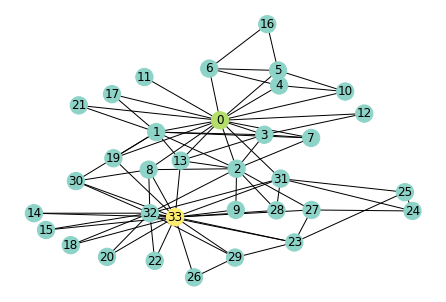

In [7]:
masked_labels = -torch.ones(34) # Unknown labels are marked as -1
masked_labels[0] = 0
masked_labels[33] = 1
nx.draw(nx_G, pos, with_labels=True, cmap=plt.get_cmap('Set3'), node_color=masked_labels, vmin=-1, vmax=1)

Step 4: Define a Graph Convolutional Network (GCN)
--------------------------------------------------
To perform node classification, use the Graph Convolutional Network
(GCN) developed by [Kipf and Welling](https://arxiv.org/abs/1609.02907). Here
is the simplest definition of a GCN framework. We recommend that you 
read the original paper for more details.

- At layer $l$, each node $v_i^l$ carries a feature vector $h_i^l$.
- Each layer of the GCN tries to aggregate the features from $u_i^{l}$ where
  $u_i$'s are neighborhood nodes to $v$ into the next layer representation at
  $v_i^{l+1}$. This is followed by an affine transformation with some
  non-linearity.

The above definition of GCN fits into a **message-passing** paradigm: Each
node will update its own feature with information sent from neighboring
nodes. A graphical demonstration is displayed below.

![mailbox](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/1_first/mailbox.png)

Now, we show that the GCN layer can be easily implemented in DGL.



In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger update on all graph
        # Sum over all neighborbood with `fn.copy_u` and `fn.sum`
        g.update_all(fn.copy_u('h', 'msg'), fn.sum('msg', 'h'))
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In general, the nodes send information computed via the *message functions*,
and aggregate incoming information with the *reduce functions*.

Here we use builtin functions `copy_u` and `sum`. More functions can be found [here](https://docs.dgl.ai/features/builtin.html).


### Define a deeper GCN model that contains two GCN layers:

In [9]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 2)

### Using pre-defined NN Module
DGL provides two ways of implementing a GNN model:
- using the nn module, which contains many commonly used GNN modules.
- using the message passing interface to implement a GNN model from scratch.
For simplicity, here we show how to implement the GNN model in the tutorial with the nn module. More detail could be found [here](https://docs.dgl.ai/api/python/nn.pytorch.html#graphconv).

In [10]:
# Define a 2-layer GCN model with DGL nn modules
from dgl.nn.pytorch import conv as dgl_conv
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        # GraphConv did more than GCNLayer defined above, it also added normalization for each node.
        # Details can be found in original paper https://arxiv.org/abs/1609.02907
        self.gcn1 = dgl_conv.GraphConv(in_feats, hidden_size, activation=F.relu) 
        self.gcn2 = dgl_conv.GraphConv(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = self.gcn2(g, h)
        return h
    
net = GCN(34, 5, 2)

Step 5: Train then visualize
----------------------------
The training loop is exactly the same as other PyTorch models.
We (1) create an optimizer, (2) feed the inputs to the model,
(3) calculate the loss and (4) use autograd to optimize the model.



In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
loss_fcn = torch.nn.CrossEntropyLoss()
all_logits = []
for epoch in range(30):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    # we only compute loss for labeled nodes
    loss = loss_fcn(logits[labeled_nodes], G.ndata['label'][labeled_nodes])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 0.6835
Epoch 1 | Loss: 0.6706
Epoch 2 | Loss: 0.6598
Epoch 3 | Loss: 0.6467
Epoch 4 | Loss: 0.6331
Epoch 5 | Loss: 0.6202
Epoch 6 | Loss: 0.6076
Epoch 7 | Loss: 0.5952
Epoch 8 | Loss: 0.5819
Epoch 9 | Loss: 0.5679
Epoch 10 | Loss: 0.5534
Epoch 11 | Loss: 0.5377
Epoch 12 | Loss: 0.5205
Epoch 13 | Loss: 0.5029
Epoch 14 | Loss: 0.4849
Epoch 15 | Loss: 0.4668
Epoch 16 | Loss: 0.4487
Epoch 17 | Loss: 0.4311
Epoch 18 | Loss: 0.4136
Epoch 19 | Loss: 0.3961
Epoch 20 | Loss: 0.3787
Epoch 21 | Loss: 0.3609
Epoch 22 | Loss: 0.3432
Epoch 23 | Loss: 0.3258
Epoch 24 | Loss: 0.3087
Epoch 25 | Loss: 0.2919
Epoch 26 | Loss: 0.2755
Epoch 27 | Loss: 0.2596
Epoch 28 | Loss: 0.2443
Epoch 29 | Loss: 0.2293


### Accuracy on all nodes

In [12]:
acc = (logits.argmax(1)==G.ndata['label']).float().mean()
print("Accuracy on all nodes: {}".format(acc))

Accuracy on all nodes: 0.8823529481887817


This is a rather toy example, so it does not even have a validation or test
set. Instead, Since the model produces an output feature of size 2 for each node, we can
visualize by plotting the output feature in a 2D space.
The following code animates the training process from initial guess
(where the nodes are not classified correctly at all) to the end
(where the nodes are linearly separable).



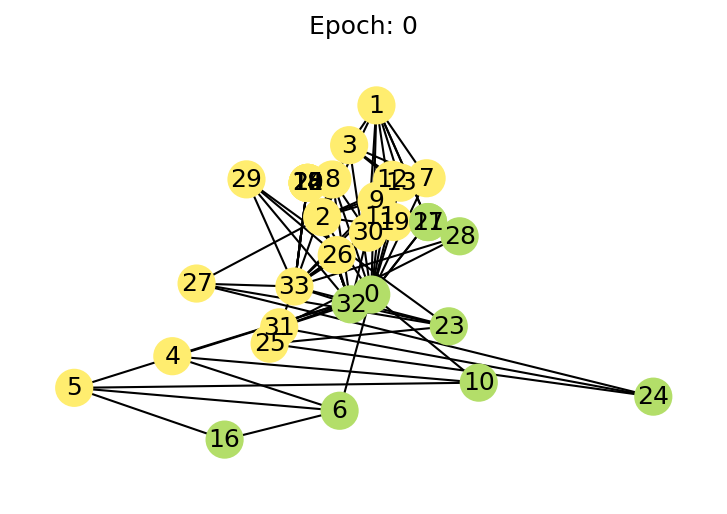

In [13]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    pred = all_logits[i]
    pred_labels = pred.argmax(1)
    pos = {}
    colors = []
    for v in range(34):
        pos[v] = pred[v].numpy()
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G, pos, cmap=plt.get_cmap('Set3'), node_color=pred_labels, vmin=-1, vmax=1,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
draw(0)  # draw the prediction of the first epoch

The following animation shows how the model correctly predicts the community
after a series of training epochs.



In [14]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=200)

In [15]:
from IPython.display import HTML
HTML(ani.to_jshtml()) # This may takes while